## 1.Importing Libraries

In [831]:
import pandas as pd
import numpy as np
import sklearn
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from feature_engine.datetime import DatetimeFeatures
from sklearn.model_selection import learning_curve,ShuffleSplit,RandomizedSearchCV
from scipy.stats import uniform, randint


## 2.Display Setting

In [832]:
pd.set_option("display.max_columns",None)

In [833]:
sklearn.set_config(transform_output="pandas")

## 3.Getting the Data

In [834]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [835]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


### 3.1 Split the Data

In [836]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

In [837]:
X_train,y_train = split_data(train_df)

In [838]:
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [839]:
X_val,y_val = split_data(val_df)

In [840]:
print(X_val.shape,y_val.shape)

(160, 9) (160,)


In [841]:
print(X_val.shape,y_val.shape)

(160, 9) (160,)


In [842]:
X_test,y_test = split_data(test_df)

print(X_test.shape,y_test.shape)

(200, 9) (200,)


### 3.2 Meta-info

In [843]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data Preprocessing

In [844]:
dt_cols = ["date_of_journey","dep_time","arrival_time"]
num_col = ["duration","total_stops"]
cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_col)]

In [845]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [846]:
num_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='median')),
    ("Scaler",StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("endcoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extract",DatetimeFeatures(features_to_extract=['month','week','day_of_week','day_of_month'],format="mixed")),
    ("Scaler",StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extract",DatetimeFeatures(features_to_extract=['hour','minute'],format="mixed")),
    ("Scaler",StandardScaler())
])

In [847]:
preprocessor = ColumnTransformer(transformers=[
    ("num",num_transformer,num_col),
    ("cat",cat_transformer,cat_cols),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time",time_transformer,['dep_time','arrival_time'])
])

In [848]:
preprocessor.fit_transform(X_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,-0.402640,-0.113711,-0.640951,-0.684960,-0.345231,-1.218823
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,-1.371399,-1.430369,1.326906,-0.140057,1.278301,1.795268
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.081739,-0.831888,0.790218,-1.229863,-0.492825,1.192450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.566118,-0.113711,-1.535432,1.767103,-0.935607,1.192450
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.081739,-0.472800,-0.640951,0.677297,1.130707,-1.218823
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-1.177640,-0.957412,-0.788013,1.493859
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-0.819847,1.222200,1.130707,-1.520232


### hyperparameter Tuning

In [849]:
param_distributions = {
    "Linear Regression": {},
    "Ridge Regression": {"alg__alpha": uniform(1.0, 20.0)},  # Increased minimum alpha
    "Support Vector Machine": {
        "alg__C": uniform(0.01, 50),  # Lowered max C for more regularization
        "alg__kernel": ["linear", "rbf"]
    },
    "Random Forest": {
        "alg__n_estimators": [200, 300, 400],
        "alg__max_depth": [3, 5, 7],  # Reduced max depth (was 5-15)
        "alg__min_samples_split": [20, 30, 40],  # Increased (was 10-30)
        "alg__min_samples_leaf": [10, 15, 20],  # Increased (was 5-15)
        "alg__max_features": ["sqrt", "log2", 0.3],  # Added more restrictive option
    },
    "XG Boost": {
        "alg__n_estimators": [200, 300, 400],
        "alg__learning_rate": [0.005, 0.01, 0.03,0.05],  # Lowered (was 0.01-0.1)
        "alg__max_depth": [3, 4, 5],  # Reduced (was 3-7)
        "alg__subsample": [0.6, 0.7, 0.8],  # Lowered (was 0.7-0.9)
        "alg__colsample_bytree": [0.6, 0.7, 0.8],  # Lowered (was 0.7-0.9)
        "alg__reg_alpha": [0, 0.1, 1.0],  # Added L1 regularization
        "alg__reg_lambda": [1.0, 2.0, 5.0],  # Added L2 regularization
    }
}

## 5. Model Selection

In [850]:
base_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression":Ridge(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

In [851]:
def tune_model(name, model, X, y, preprocessor):
    """Perform hyperparameter tuning and return the best model."""
    if name in param_distributions and param_distributions[name]:  # If tuning is needed
        pipeline = Pipeline(steps=[("pre", preprocessor), ("alg", model)])
        search = RandomizedSearchCV(
            pipeline, param_distributions[name], n_iter=50, cv=5, 
            scoring="r2", n_jobs=-1, verbose=1, random_state=42
        )
        search.fit(X, y)
        print(f"Best parameters for {name}: {search.best_params_}")
        return search.best_estimator_
    else:
        return Pipeline(steps=[("pre", preprocessor), ("alg", model)])  # Return unmodified model if no tuning

In [852]:
data = pd.concat([train_df,val_df],axis=0)
X_data,y_data = split_data(data)
print(X_data.shape,y_data.shape)

(800, 9) (800,)


In [853]:
def plot_curve(sizes, mean_scores, std_scores, label, ax):
    ax.plot(sizes, mean_scores, marker="o", label=label)
    ax.fill_between(sizes, mean_scores - std_scores, mean_scores + std_scores, alpha=0.5)

In [854]:
def plot_learning_curve(name, model, X, y, preprocessor, figsize=(12, 4)):
    """Train the model with optimal hyperparameters and plot the learning curve."""
    model = tune_model(name, model, X, y, preprocessor)  # Perform hyperparameter tuning

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model, X=X, y=y, cv=5, scoring="r2", n_jobs=-1
    )

    # Compute mean and std dev
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:2f} +/-{std_train_scores[-1]:2f}"
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:2f} +/-{std_test_scores[-1]:2f}"

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    plot_curve(train_sizes, mean_train_scores, std_train_scores, f"Train({train_score})", ax)
    plot_curve(train_sizes, mean_test_scores, std_test_scores, f"Test({test_score})", ax)

    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("R-squared")
    ax.set_title(name)
    ax.legend(loc="lower right")

    plt.show()

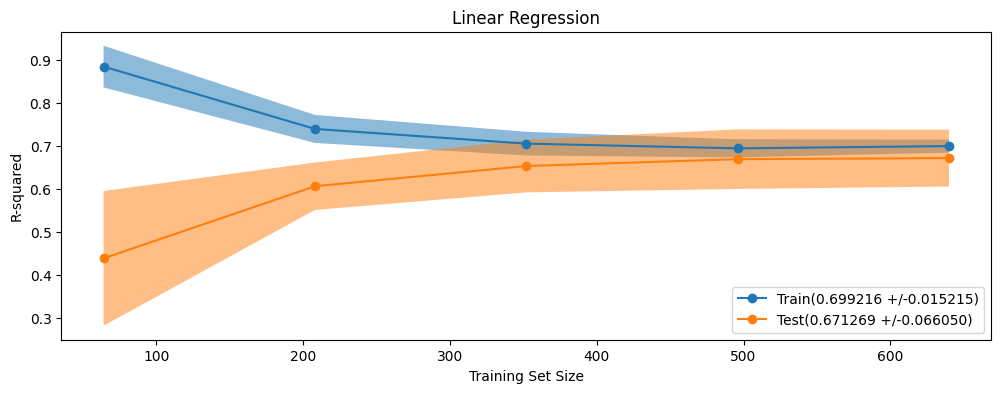

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Ridge Regression: {'alg__alpha': np.float64(2.3010318597055903)}


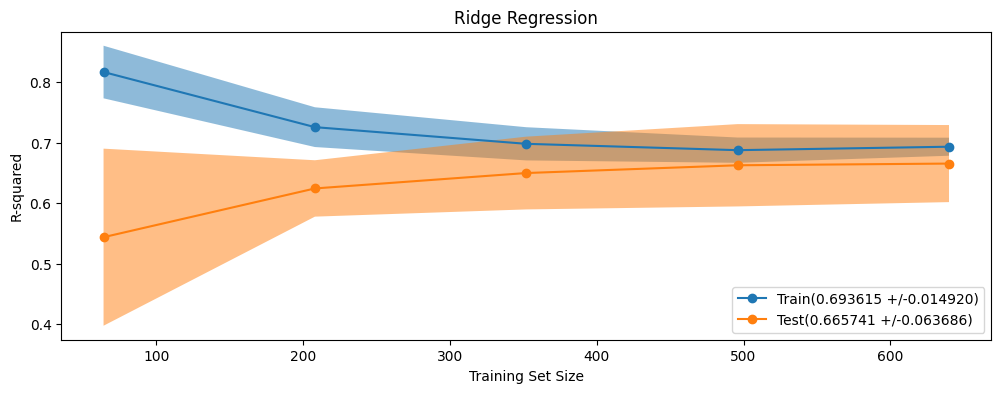

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Support Vector Machine: {'alg__C': np.float64(48.69777594207296), 'alg__kernel': 'linear'}


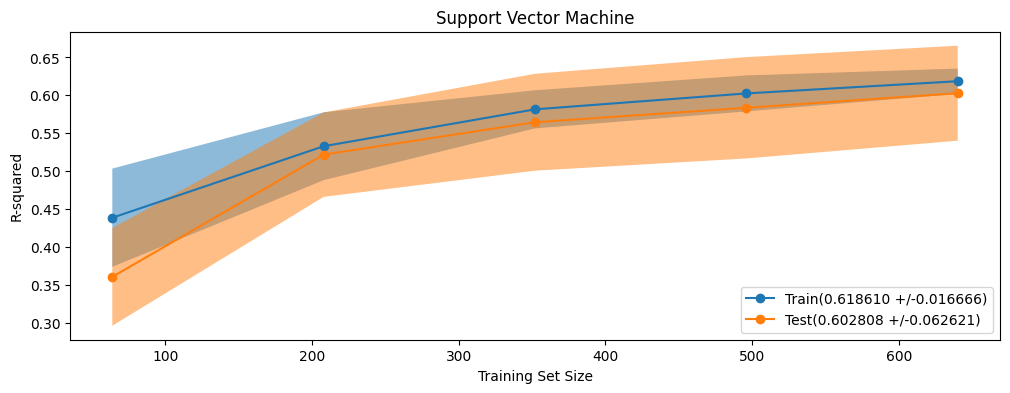

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Random Forest: {'alg__n_estimators': 300, 'alg__min_samples_split': 20, 'alg__min_samples_leaf': 10, 'alg__max_features': 0.3, 'alg__max_depth': 7}


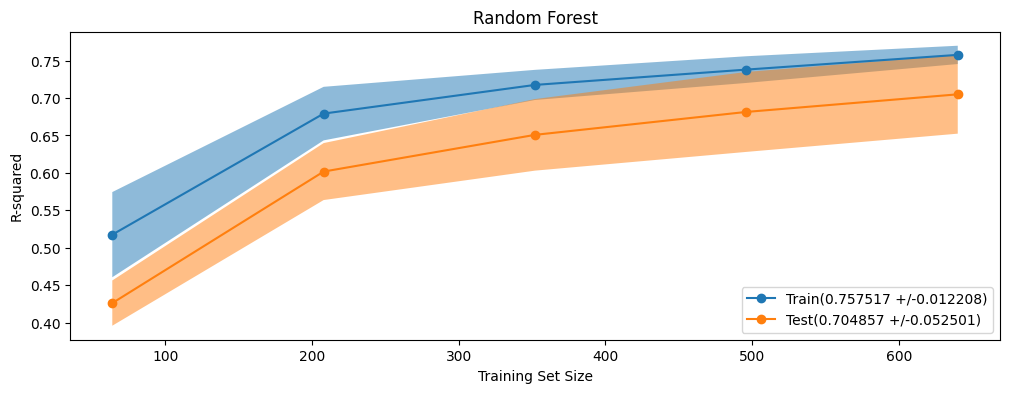

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XG Boost: {'alg__subsample': 0.7, 'alg__reg_lambda': 2.0, 'alg__reg_alpha': 1.0, 'alg__n_estimators': 200, 'alg__max_depth': 4, 'alg__learning_rate': 0.05, 'alg__colsample_bytree': 0.7}


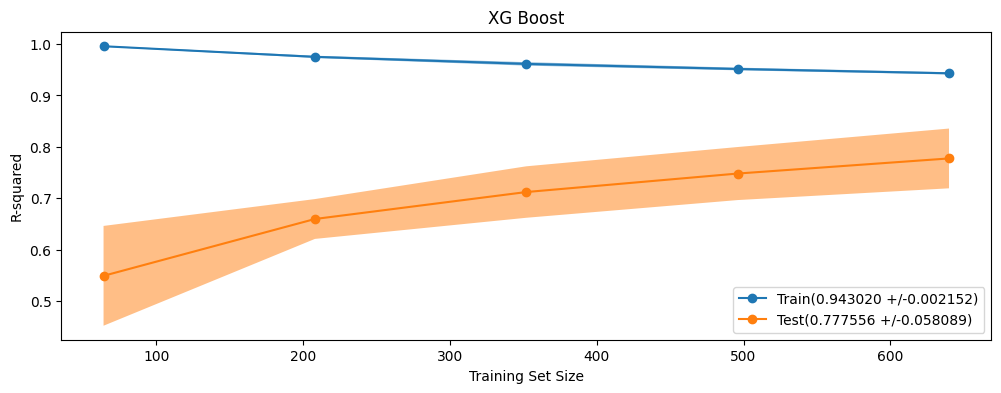

In [855]:
for name, model in base_models.items():
    plot_learning_curve(name, model, X_data, y_data, preprocessor)

## 6. Model Training

In [856]:
model = Pipeline(steps=[
    ("pre",preprocessor),
    ("rf",RandomForestRegressor(n_estimators=300,min_samples_split=20,min_samples_leaf=10,max_features=0.3,max_depth=7))
    
])

In [857]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('endcoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',...
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extract',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf',
                 RandomForestRegressor(max_depth=7, max_features=0.3,
                                       min_samples_leaf=10,
                                       min_samples_split=20,
                                       n_estimators=300))])

## 7. Model Evatualtion

In [858]:
def evaluation_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)

In [859]:
print(f"R2 score on Training data is = {evaluation_model(X_data,y_data)}")

R2 score on Training data is = 0.7638079992754939


In [860]:
print(f"R2 score on Training data is = {evaluation_model(X_test,y_test)}")

R2 score on Training data is = 0.7189385117553262


## Model Persistence

In [861]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [862]:
saved_model = joblib.load("model.joblib")

In [863]:
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('endcoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',...
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extract',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf',
                 RandomForestRegressor(max_depth=7, max_features=0.3,
                                       min_samples_leaf=10,
                                       min_samples_split=20,
                                       n_estimators=300))])

In [864]:
y_pred = saved_model.predict(X_test)

r2_score(y_test,y_pred)

0.7189385117553262